
# Clasificación Breast Cancer con Pipelines (Logistic Regression & Random Forest)

Este notebook replica el flujo típico que usamos con *Titanic*, pero aplicado al dataset **Breast Cancer Wisconsin** de `scikit-learn`:

- Carga y exploración rápida de datos
- Split train/test con estratificación
- **Pipelines** con `StandardScaler` + `LogisticRegression` y `RandomForestClassifier`
- Validación cruzada y tabla comparativa de métricas
- Curvas ROC/PR y matriz de confusión
- **GridSearchCV** (búsqueda de hiperparámetros) para ambos modelos
- Interpretabilidad: coeficientes (LR) e importancias (RF)

> Nota: Todos los features son numéricos, por lo que no necesitamos `ColumnTransformer` aquí, pero dejamos el patrón de *pipeline* para mantener la estructura.


In [ ]:
# === Setup ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, RocCurveDisplay, PrecisionRecallDisplay, ConfusionMatrixDisplay, classification_report
)

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
plt.rcParams['figure.figsize'] = (7, 5)


## 1) Carga de datos y DataFrame

In [ ]:
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target, name='target')  # 0 = malignant, 1 = benign

X.sample(5, random_state=RANDOM_STATE)


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
204,12.47,18.60,81.09,481.9,0.09965,0.1058,0.08005,0.03821,0.1925,0.06373,...,14.97,24.64,96.05,677.9,0.1426,0.2378,0.2671,0.10150,0.3014,0.08750
70,18.94,21.31,123.60,1130.0,0.09009,0.1029,0.10800,0.07951,0.1582,0.05461,...,24.86,26.58,165.90,1866.0,0.1193,0.2336,0.2687,0.17890,0.2551,0.06589
131,15.46,19.48,101.70,748.9,0.10920,0.1223,0.14660,0.08087,0.1931,0.05796,...,19.26,26.00,124.90,1156.0,0.1546,0.2394,0.3791,0.15140,0.2837,0.08019
431,12.40,17.68,81.47,467.8,0.10540,0.1316,0.07741,0.02799,0.1811,0.07102,...,12.88,22.91,89.61,515.8,0.1450,0.2629,0.2403,0.07370,0.2556,0.09359
540,11.54,14.44,74.65,402.9,0.09984,0.1120,0.06737,0.02594,0.1818,0.06782,...,12.26,19.68,78.78,457.8,0.1345,0.2118,0.1797,0.06918,0.2329,0.08134


### Info rápida

In [ ]:
display(X.describe().T)
print("\nShape:", X.shape)
print("Clases:", dict(zip(data.target_names, np.bincount(y))))


,count,mean,std,min,25%,50%,75%,max
mean radius,569.0,14.127292,3.524049,6.981000,11.700000,13.370000,15.780000,28.11000
mean texture,569.0,19.289649,4.301036,9.710000,16.170000,18.840000,21.800000,39.28000
mean perimeter,569.0,91.969033,24.298981,43.790000,75.170000,86.240000,104.100000,188.50000
mean area,569.0,654.889104,351.914129,143.500000,420.300000,551.100000,782.700000,2501.00000
mean smoothness,569.0,0.096360,0.014064,0.052630,0.086370,0.095870,0.105300,0.16340
mean compactness,569.0,0.104341,0.052813,0.019380,0.064920,0.092630,0.130400,0.34540
mean concavity,569.0,0.088799,0.079720,0.000000,0.029560,0.061540,0.130700,0.42680
mean concave points,569.0,0.048919,0.038803,0.000000,0.020310,0.033500,0.074000,0.20120
mean symmetry,569.0,0.181162,0.027414,0.106000,0.161900,0.179200,0.195700,0.30400
mean fractal dimension,569.0,0.062798,0.007060,0.049960,0.057700,0.061540,0.066120,0.09744



Shape: (569, 30)
Clases: {np.str_('malignant'): np.int64(212), np.str_('benign'): np.int64(357)}


## 2) Train/Test split (estratificado)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)
X_train.shape, X_test.shape


((455, 30), (114, 30))

## 3) Pipelines base

In [ ]:
pipe_lr = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=500, random_state=RANDOM_STATE))
])

pipe_rf = Pipeline([
    ("clf", RandomForestClassifier(random_state=RANDOM_STATE))
])

pipe_lr, pipe_rf


(Pipeline(steps=[('scaler', StandardScaler()),
                 ('clf', LogisticRegression(max_iter=500, random_state=42))]),
 Pipeline(steps=[('clf', RandomForestClassifier(random_state=42))]))

## 4) Validación cruzada y comparativa de modelos

In [ ]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
scoring = {
    "accuracy": "accuracy",
    "precision": "precision",
    "recall": "recall",
    "f1": "f1",
    "roc_auc": "roc_auc"
}

cv_lr = cross_validate(pipe_lr, X_train, y_train, cv=cv, scoring=scoring, n_jobs=-1)
cv_rf = cross_validate(pipe_rf, X_train, y_train, cv=cv, scoring=scoring, n_jobs=-1)

def summarize_cv(cvres, label):
    return pd.Series({
        "model": label,
        **{f"{m}_mean": np.mean(cvres[f'test_{m}']) for m in scoring.keys()},
        **{f"{m}_std": np.std(cvres[f'test_{m}']) for m in scoring.keys()},
    })

summary = pd.concat([summarize_cv(cv_lr, "LogisticRegression"), summarize_cv(cv_rf, "RandomForest")], axis=1).T
summary.sort_values("roc_auc_mean", ascending=False).reset_index(drop=True)


,model,accuracy_mean,precision_mean,recall_mean,f1_mean,roc_auc_mean,accuracy_std,precision_std,recall_std,f1_std,roc_auc_std
0,LogisticRegression,0.978022,0.979472,0.985965,0.982544,0.995872,0.009829,0.016229,0.013129,0.007752,0.00496
1,RandomForest,0.962637,0.975519,0.964912,0.969935,0.989577,0.017855,0.017177,0.024811,0.014605,0.008257


## 5) Entrenamiento y evaluación en test

In [ ]:
# Entrenamos
pipe_lr.fit(X_train, y_train)
pipe_rf.fit(X_train, y_train)

# Predicciones + probabilidades
y_pred_lr = pipe_lr.predict(X_test)
y_proba_lr = pipe_lr.predict_proba(X_test)[:, 1]

y_pred_rf = pipe_rf.predict(X_test)
y_proba_rf = pipe_rf.predict_proba(X_test)[:, 1]

def metrics_row(y_true, y_pred, y_proba, label):
    return pd.Series({
        "model": label,
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred),
        "recall": recall_score(y_true, y_pred),
        "f1": f1_score(y_true, y_pred),
        "roc_auc": roc_auc_score(y_true, y_proba),
    })

test_metrics = pd.concat([
    metrics_row(y_test, y_pred_lr, y_proba_lr, "LogisticRegression"),
    metrics_row(y_test, y_pred_rf, y_proba_rf, "RandomForest")
], axis=1).T

test_metrics


,model,accuracy,precision,recall,f1,roc_auc
0,LogisticRegression,0.982456,0.986111,0.986111,0.986111,0.99537
1,RandomForest,0.95614,0.958904,0.972222,0.965517,0.993717


### Matrices de confusión

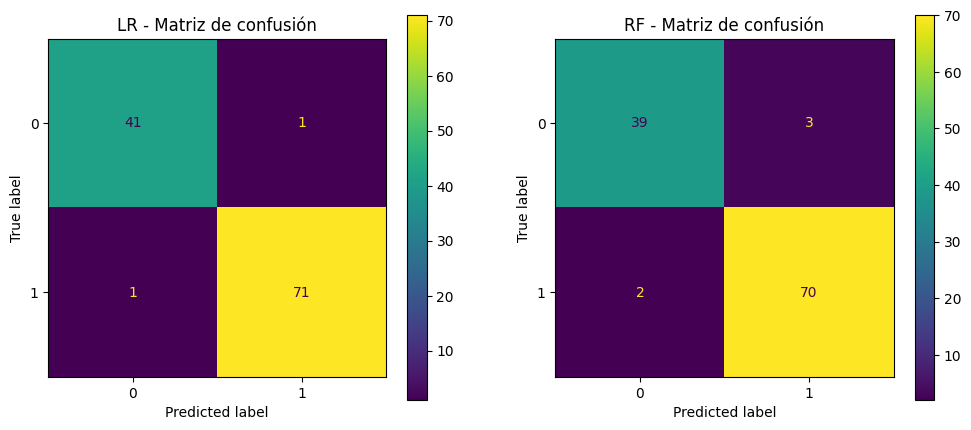

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_lr)).plot(ax=axes[0])
axes[0].set_title("LR - Matriz de confusión")
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_rf)).plot(ax=axes[1])
axes[1].set_title("RF - Matriz de confusión")
plt.show()


### Curvas ROC y Precision-Recall

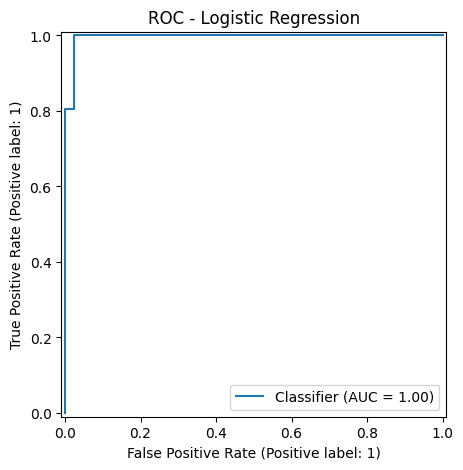

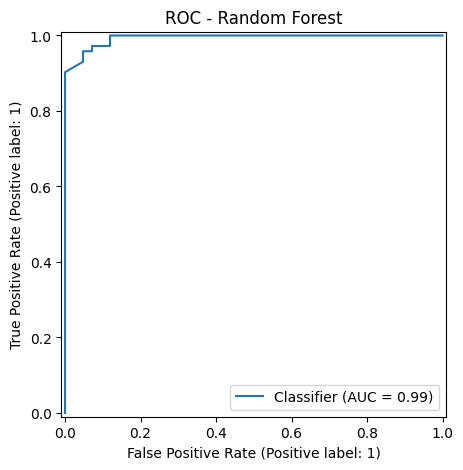

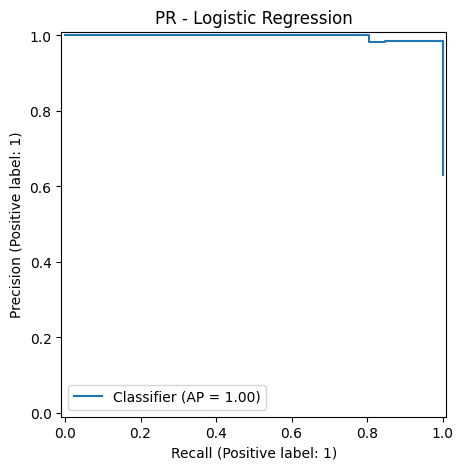

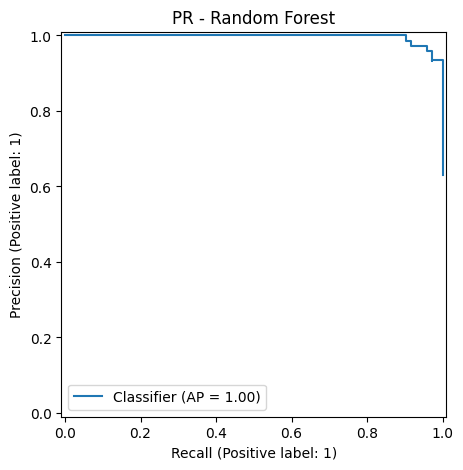

In [ ]:
# ROC
RocCurveDisplay.from_predictions(y_test, y_proba_lr)
plt.title("ROC - Logistic Regression")
plt.show()

RocCurveDisplay.from_predictions(y_test, y_proba_rf)
plt.title("ROC - Random Forest")
plt.show()

# Precision-Recall
PrecisionRecallDisplay.from_predictions(y_test, y_proba_lr)
plt.title("PR - Logistic Regression")
plt.show()

PrecisionRecallDisplay.from_predictions(y_test, y_proba_rf)
plt.title("PR - Random Forest")
plt.show()


## 6) Interpretabilidad (coeficientes e importancias)

In [ ]:
# Coeficientes LR
lr = pipe_lr.named_steps["clf"]
scaler = pipe_lr.named_steps["scaler"]

coefs = pd.DataFrame({
    "feature": X_train.columns,
    "coef": lr.coef_.flatten()
}).sort_values("coef", key=abs, ascending=False)

coefs.head(10)


,feature,coef
21,worst texture,-1.255088
10,radius error,-1.082965
27,worst concave points,-0.953686
23,worst area,-0.947756
20,worst radius,-0.947616
28,worst symmetry,-0.939181
13,area error,-0.929104
26,worst concavity,-0.823151
22,worst perimeter,-0.763220
24,worst smoothness,-0.746625


In [ ]:
# Importancias RF
rf = pipe_rf.named_steps["clf"]
importances = pd.DataFrame({
    "feature": X_train.columns,
    "importance": rf.feature_importances_
}).sort_values("importance", ascending=False)

importances.head(10)


,feature,importance
23,worst area,0.140016
27,worst concave points,0.129530
20,worst radius,0.097696
7,mean concave points,0.090885
22,worst perimeter,0.072226
2,mean perimeter,0.069574
0,mean radius,0.068676
6,mean concavity,0.057638
3,mean area,0.049172
26,worst concavity,0.034340


## 7) Búsqueda de hiperparámetros (GridSearchCV)

In [26]:

param_grid_lr = {
    "clf__C": [0.01, 0.1, 1.0, 10.0],
    "clf__penalty": ["l2"],
    "clf__solver": ["lbfgs", "liblinear"]
}
grid_lr = GridSearchCV(pipe_lr, param_grid_lr, cv=cv, scoring="roc_auc", n_jobs=-1)
grid_lr.fit(X_train, y_train)

print("Mejor LR:", grid_lr.best_params_, "AUC:", grid_lr.best_score_)


Mejor LR: {'clf__C': 1.0, 'clf__penalty': 'l2', 'clf__solver': 'liblinear'} AUC: 0.9959752321981423


In [27]:

param_grid_rf = {
    "clf__n_estimators": [200, 400],
    "clf__max_depth": [None, 4, 6, 8],
    "clf__min_samples_split": [2, 5, 10],
    "clf__min_samples_leaf": [1, 2, 4],
    "clf__max_features": ["sqrt", "log2"]
}
grid_rf = GridSearchCV(pipe_rf, param_grid_rf, cv=cv, scoring="roc_auc", n_jobs=-1)
grid_rf.fit(X_train, y_train)

print("Mejor RF:", grid_rf.best_params_, "AUC:", grid_rf.best_score_)


Mejor RF: {'clf__max_depth': 4, 'clf__max_features': 'sqrt', 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2, 'clf__n_estimators': 200} AUC: 0.9912280701754387


### Evaluación en test con los mejores modelos

In [28]:

best_lr = grid_lr.best_estimator_
best_rf = grid_rf.best_estimator_

for label, model in [("Best LR", best_lr), ("Best RF", best_rf)]:
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    print(f"\n=== {label} ===")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall:", recall_score(y_test, y_pred))
    print("F1:", f1_score(y_test, y_pred))
    print("ROC AUC:", roc_auc_score(y_test, y_proba))



=== Best LR ===
Accuracy: 0.9824561403508771
Precision: 0.9861111111111112
Recall: 0.9861111111111112
F1: 0.9861111111111112
ROC AUC: 0.9957010582010581

=== Best RF ===
Accuracy: 0.956140350877193
Precision: 0.958904109589041
Recall: 0.9722222222222222
F1: 0.9655172413793104
ROC AUC: 0.9927248677248677


## 8) Exportar modelos entrenados (opcional)

In [ ]:

import joblib

joblib.dump(best_lr, "breast_cancer_best_lr.joblib")
joblib.dump(best_rf, "breast_cancer_best_rf.joblib")

print("Guardados: breast_cancer_best_lr.joblib, breast_cancer_best_rf.joblib")



---

### Notas finales
- Puedes extender este notebook añadiendo calibración de probabilidades, curvas de aprendizaje y validación, o *permutation importance*.
- Si quieres replicar exactamente la estructura del Titanic (p. ej. preprocesado de categóricas, imputación, `ColumnTransformer`), te preparo una variante con un dataset que mezcle numéricas y categóricas (p. ej. **Heart Disease**).
